In [1]:
import os
import glob
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("default") 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pandas as pd

import geopandas as gpd

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point, LineString, Polygon, mapping

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.plot import plotting_extent
from rasterio.crs import CRS
from rasterio.io import MemoryFile
import tempfile

# National Land Cover Database (NLCD)

The National Land Cover Database 2019 (NLCD 2019) is a national land cover product created by the Multi-Resolution Land Characteristics (MRLC) Consortium. The data have been clipped for Texas only.

NLCD 2019 provides the capability to assess wall-to-wall, spatially explicit, national land cover changes and trends across the United States from 2001 to 2019. As with three previous NLCD land cover products NLCD 2019 keeps the same 16-class land cover classification scheme that has been applied consistently across the United States at a spatial resolution of 30 meters. NLCD 2019 is based on assembling and preprocessing Landsat imagery and geospatial ancillary datasets and a multi-source integrated training data development and machine learning based land cover classifications.

#### Source Contact
- tnm_help@usgs.gov

#### File Type
- IMG

#### Resolution
- 30m

#### Category
- Basemap,Land_Cover

#### Other links: 
- https://www.mrlc.gov/
- https://developers.google.com/earth-engine/datasets/catalog/USGS_NLCD_RELEASES_2019_REL_NLCD#description
- https://data.tnris.org/collection/?c=97a6ce2e-8a4c-4570-a3ed-983ef1a4554b

In [ ]:
# Define the coordinates
coords = (30.086982, -95.763325)

# Create a Point geometry
geometry = [Point(coords[::-1])]  # Note: Point takes in (x, y) so we reverse the tuple

# Create a GeoDataFrame
sample_location = gpd.GeoDataFrame({'geometry': geometry}, crs="EPSG:4326")

sample_location

In [2]:
# Working Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_NA_TX_Data')
# Shapes
tx = gpd.read_file('Texas_State_Boundary')
tx_co = gpd.read_file('Texas_County_Boundaries_Detailed')
tx_watershed = gpd.read_file('tx_watershed')
Counties_1 = gpd.read_file('Counties_1')
Counties_1_Merged = gpd.read_file('Counties_1_Merged')
Hockly_HUCs = gpd.read_file('Hockly_HUCs')

In [3]:
# Watershed Boundaries
huc8 = "J:///Chomiak_Python/Chomiak_Notebooks/Maps_NA_TX_Data/USGS_HUC_8_Shapefile.zip"    # HUC8
huc8 = gpd.read_file(huc8)    # HUC8
huc8.crs = CRS.from_epsg(4326)       # Change the CRS of the File (Previously 4269)

# San Jacinto Basin (HUC = 120401)  
h1 = huc8[huc8['HUC_8'] == '12040101']
h2 = huc8[huc8['HUC_8'] == '12040102']
h3 = huc8[huc8['HUC_8'] == '12040103']
h4 = huc8[huc8['HUC_8'] == '12040104']

# List of Relevant Tags
huc = ['12040101', '12040102', '12040103', '12040104']

# Concatenate the dfs
huc = gpd.pd.concat([h1,h2,h3,h4])

# Create a Boundary Shape for Plots
polygon = huc.geometry.unary_union
mask_huc = gpd.GeoDataFrame(geometry=[polygon])

print(list(huc['SUBBASIN'].unique())) # Sub-Basins

huc

['West Fork San Jacinto', 'Spring', 'East Fork San Jacinto', 'Buffalo-San Jacinto']


HUC_8 HUC_2 HUC_4   HUC_6   Shape_Le_1    Shape_Ar_1  \
74  12040101    12  1204  120401  46667.38533  7.012646e+07   
75  12040102    12  1204  120401  46667.38533  7.012646e+07   
76  12040103    12  1204  120401  46667.38533  7.012646e+07   
77  12040104    12  1204  120401  46667.38533  7.012646e+07   

                 SUBBASIN             REGION                  SUBREGION  \
74  West Fork San Jacinto  Texas-Gulf Region  Galveston Bay-San Jacinto   
75                 Spring  Texas-Gulf Region  Galveston Bay-San Jacinto   
76  East Fork San Jacinto  Texas-Gulf Region  Galveston Bay-San Jacinto   
77    Buffalo-San Jacinto  Texas-Gulf Region  Galveston Bay-San Jacinto   

          BASIN                                           geometry  
74  San Jacinto  POLYGON ((-95.54109 30.70281, -95.54131 30.701...  
75  San Jacinto  POLYGON ((-95.31235 30.02065, -95.31235 30.020...  
76  San Jacinto  POLYGON ((-94.99246 30.44548, -94.99119 30.443...  
77  San Jacinto  MULTIPOLYGON (((-95.26184 29.69675, -95.26191 ...

In [4]:
h2

HUC_8 HUC_2 HUC_4   HUC_6   Shape_Le_1    Shape_Ar_1 SUBBASIN  \
75  12040102    12  1204  120401  46667.38533  7.012646e+07   Spring   

               REGION                  SUBREGION        BASIN  \
75  Texas-Gulf Region  Galveston Bay-San Jacinto  San Jacinto   

                                             geometry  
75  POLYGON ((-95.31235 30.02065, -95.31235 30.020...

In [5]:
# sample point
#coordinatez = (30.086982, -95.763325)

In [6]:
# Folder of Interest (Contains NLCD 2019 Data)
raster_folder = 'nlcd19_48_lc'

In [7]:
# Automated File Search for a Folder
def get_file_types_and_counts(folder_path):
    """
    Get the file types and their counts for a given folder.
    
    Parameters:
    - folder_path (str): The path to the folder to explore.
    
    Returns:
    - dict: A dictionary with file extensions as keys and their counts as values.
    """
    # List all files in the folder
    all_files = glob.glob(os.path.join(folder_path, "*"))
    
    # Extract file extensions
    file_types = [os.path.splitext(file)[1] for file in all_files]
    
    # Count occurrences of each file type
    file_type_counts = {file_type: file_types.count(file_type) for file_type in set(file_types)}
    
    return file_type_counts

In [8]:
get_file_types_and_counts(raster_folder)

{'.cpg': 1, '.rrd': 2, '.rde': 1, '.img': 2, '.xml': 2, '.dbf': 1}

In [9]:
# Automated File Search for a Folder and Sub-Folders
def explore_folder(folder_path):
    """
    Explore the content of a folder and its sub-folders.
    
    Parameters:
    - folder_path (str): The path to the folder to explore.
    
    Returns:
    - tuple: A tuple containing two dictionaries. The first dictionary has the file types and their counts for the main folder.
             The second dictionary has the file types and their counts for the sub-folder.
    """
    # Get file types and counts for the main folder
    main_folder_counts = get_file_types_and_counts(folder_path)
    
    # Identify the sub-folder(s) within the provided directory
    sub_folders = [f for f in glob.glob(os.path.join(folder_path, "*")) if os.path.isdir(f)]
    
    # If there's a sub-folder, explore it
    if sub_folders:
        sub_folder_counts = get_file_types_and_counts(sub_folders[0])
    else:
        sub_folder_counts = {}
    
    return main_folder_counts, sub_folder_counts

In [10]:
# There is no Subfolder
main_counts, sub_folder_counts = explore_folder(raster_folder)
main_counts, sub_folder_counts

({'.cpg': 1, '.rrd': 2, '.rde': 1, '.img': 2, '.xml': 2, '.dbf': 1}, {})

.img: This is an Erdas Imagine file format, often used for storing raster data.
.xml: XML files associated with metadata or configuration for some of the data files.
.rde: Not a standard GIS extension I'm familiar with, but it could be some related metadata or configuration file.
.rrd: These are reduced resolution dataset files often associated with .img files. They're used for quick overviews at different zoom levels.
.cpg: This defines the character encoding for a shapefile attribute table. It goes along with shapefiles.
.dbf: This is a database file associated with a shapefile, containing attribute information.

In [11]:
# Get File Sizes

# List all files in the folder using glob
all_files = glob.glob(os.path.join(raster_folder))
# Get just the filenames (without full path)
file_names = [os.path.basename(file) for file in all_files]
# Get the sizes of the files in megabytes
file_sizes_mb = [os.path.getsize(file) / (1024 * 1024) for file in all_files]
# Pair filenames with their sizes
file_info = list(zip(file_names, file_sizes_mb))
for name, size in file_info:
    print(f"{name}: {size:.2f} MB")

nlcd19_48_lc: 0.00 MB


In [12]:
with rasterio.open('nlcd19_48_lc\\nlcd_2019_land_cover_l48_20210604_TX.img') as src:
    # Displaying the basic metadata
    metadata = src.meta
    crs = src.crs
    resolution = src.res
    bounds = src.bounds
    
metadata, crs, resolution, bounds

({'driver': 'HFA',
  'dtype': 'int8',
  'nodata': -128.0,
  'width': 44254,
  'height': 41260,
  'count': 1,
  'crs': CRS.from_wkt('PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
  'transform': Affine(30.0, 0.0, -1075365.0,
         0.0, -30.0, 1547655.0)},
 CRS.from_wkt('PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_E

# Reporject Shapefile to Match Raster

In [13]:
Hockly_HUCs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
# Reproject the shapefile to match the raster's CRS
raster_crs = 'PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
Hockly_HUCs_reprojected = Hockly_HUCs.to_crs(raster_crs)

In [15]:
# Reproject the shapefile to match the raster's CRS
raster_crs = 'PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
huc_reprojected = huc.to_crs(raster_crs)

In [16]:
# Reproject the shapefile to match the raster's CRS
raster_crs = 'PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
h2_reprojected = h2.to_crs(raster_crs)

# Clip to SJRB

In [17]:
with rasterio.open('nlcd19_48_lc\\nlcd_2019_land_cover_l48_20210604_TX.img') as src:
    # Clip the raster
    clipped_image, clipped_transform = mask(src, Hockly_HUCs_reprojected.geometry, crop=True)
    clipped_meta = src.meta
    
    # Update metadata after clipping
    clipped_meta.update({
        "driver": "GTiff",
        "height": clipped_image.shape[1],
        "width": clipped_image.shape[2],
        "transform": clipped_transform
    })
    
    # Save the clipped raster
    with rasterio.open("NLCD_2019_Hockley_HUC.img", "w", **clipped_meta) as dest:
        dest.write(clipped_image)

### Color Code via GEE

In [18]:
# Data
data = {
    'Value': [11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 51, 52, 71, 72, 73, 74, 81, 82, 90, 95],
    'Color': ['#466b9f', '#d1def8', '#dec5c5', '#d99282', '#eb0000', '#ab0000', '#b3ac9f', '#68ab5f', '#1c5f2c', '#b5c58f', '#af963c', '#ccb879', '#dfdfc2', '#d1d182', '#a3cc51', '#82ba9e', '#dcd939', '#ab6c28', '#b8d9eb', '#6c9fb8'],
    'Description': [
        'Open water: areas of open water, generally with less than 25% cover of vegetation or soil.',
        'Perennial ice/snow: areas characterized by a perennial cover of ice and/or snow, generally greater than 25% of total cover.',
        'Developed, open space: areas with a mixture of some constructed materials, but mostly vegetation in the form of lawn grasses. Impervious surfaces account for less than 20% of total cover.',
        'Developed, low intensity: areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 20% to 49% percent of total cover.',
        'Developed, medium intensity: areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 50% to 79% of the total cover.',
        'Developed high intensity: highly developed areas where people reside or work in high numbers. Examples include apartment complexes, row houses, and commercial/industrial. Impervious surfaces account for 80% to 100% of the total cover.',
        'Barren land (rock/sand/clay): areas of bedrock, desert pavement, scarps, talus, slides, volcanic material, glacial debris, sand dunes, strip mines, gravel pits, and other accumulations of earthen material. Generally, vegetation accounts for less than 15% of total cover.',
        'Deciduous forest: areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species shed foliage simultaneously in response to seasonal change.',
        'Evergreen forest: areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species maintain their leaves all year. Canopy is never without green foliage.',
        'Mixed forest: areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. Neither deciduous nor evergreen species are greater than 75% of total tree cover.',
        'Dwarf scrub: Alaska only areas dominated by shrubs less than 20 centimeters tall with shrub canopy typically greater than 20% of total vegetation. This type is often co-associated with grasses, sedges, herbs, and non-vascular vegetation.',
        'Shrub/scrub: areas dominated by shrubs less than 5 meters tall with shrub canopy typically greater than 20% of total vegetation. This class includes true shrubs, young trees in an early successional stage, or trees stunted from environmental conditions.',
        'Grassland/herbaceous: areas dominated by gramanoid or herbaceous vegetation, generally greater than 80% of total vegetation. These areas are not subject to intensive management such as tilling, but can be utilized for grazing.',
        'Sedge/herbaceous: Alaska only areas dominated by sedges and forbs, generally greater than 80% of total vegetation. This type can occur with significant other grasses or other grass like plants, and includes sedge tundra and sedge tussock tundra.',
        'Lichens: Alaska only areas dominated by fruticose or foliose lichens generally greater than 80% of total vegetation.',
        'Moss: Alaska only areas dominated by mosses, generally greater than 80% of total vegetation.',
        'Pasture/hay: areas of grasses, legumes, or grass-legume mixtures planted for livestock grazing or the production of seed or hay crops, typically on a perennial cycle. Pasture/hay vegetation accounts for greater than 20% of total vegetation.',
        'Cultivated crops: areas used for the production of annual crops, such as corn, soybeans, vegetables, tobacco, and cotton, and also perennial woody crops such as orchards and vineyards. Crop vegetation accounts for greater than 20% of total vegetation. This class also includes all land being actively tilled.',
        'Woody wetlands: areas where forest or shrubland vegetation accounts for greater than 20% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.',
        'Emergent herbaceous wetlands: areas where perennial herbaceous vegetation accounts for greater than 80% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.'
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Split the 'Description' column into two columns
df[['Name', 'Description']] = df['Description'].str.split(':', 1, expand=True)

# Strip any leading or trailing whitespace
df['Name'] = df['Name'].str.strip()
df['Description'] = df['Description'].str.strip()

# Display the updated DataFrame
df = df[['Value', 'Color', 'Name', 'Description']]

In [19]:
df.to_csv('NLCD_2019_Attribute_Tables.csv')

In [20]:
# Extract colors from table
colors = df['Color'].tolist()
# Create the colormap
cmap = plt.matplotlib.colors.ListedColormap(colors)
norm = plt.matplotlib.colors.BoundaryNorm(df['Value'].tolist(), cmap.N)

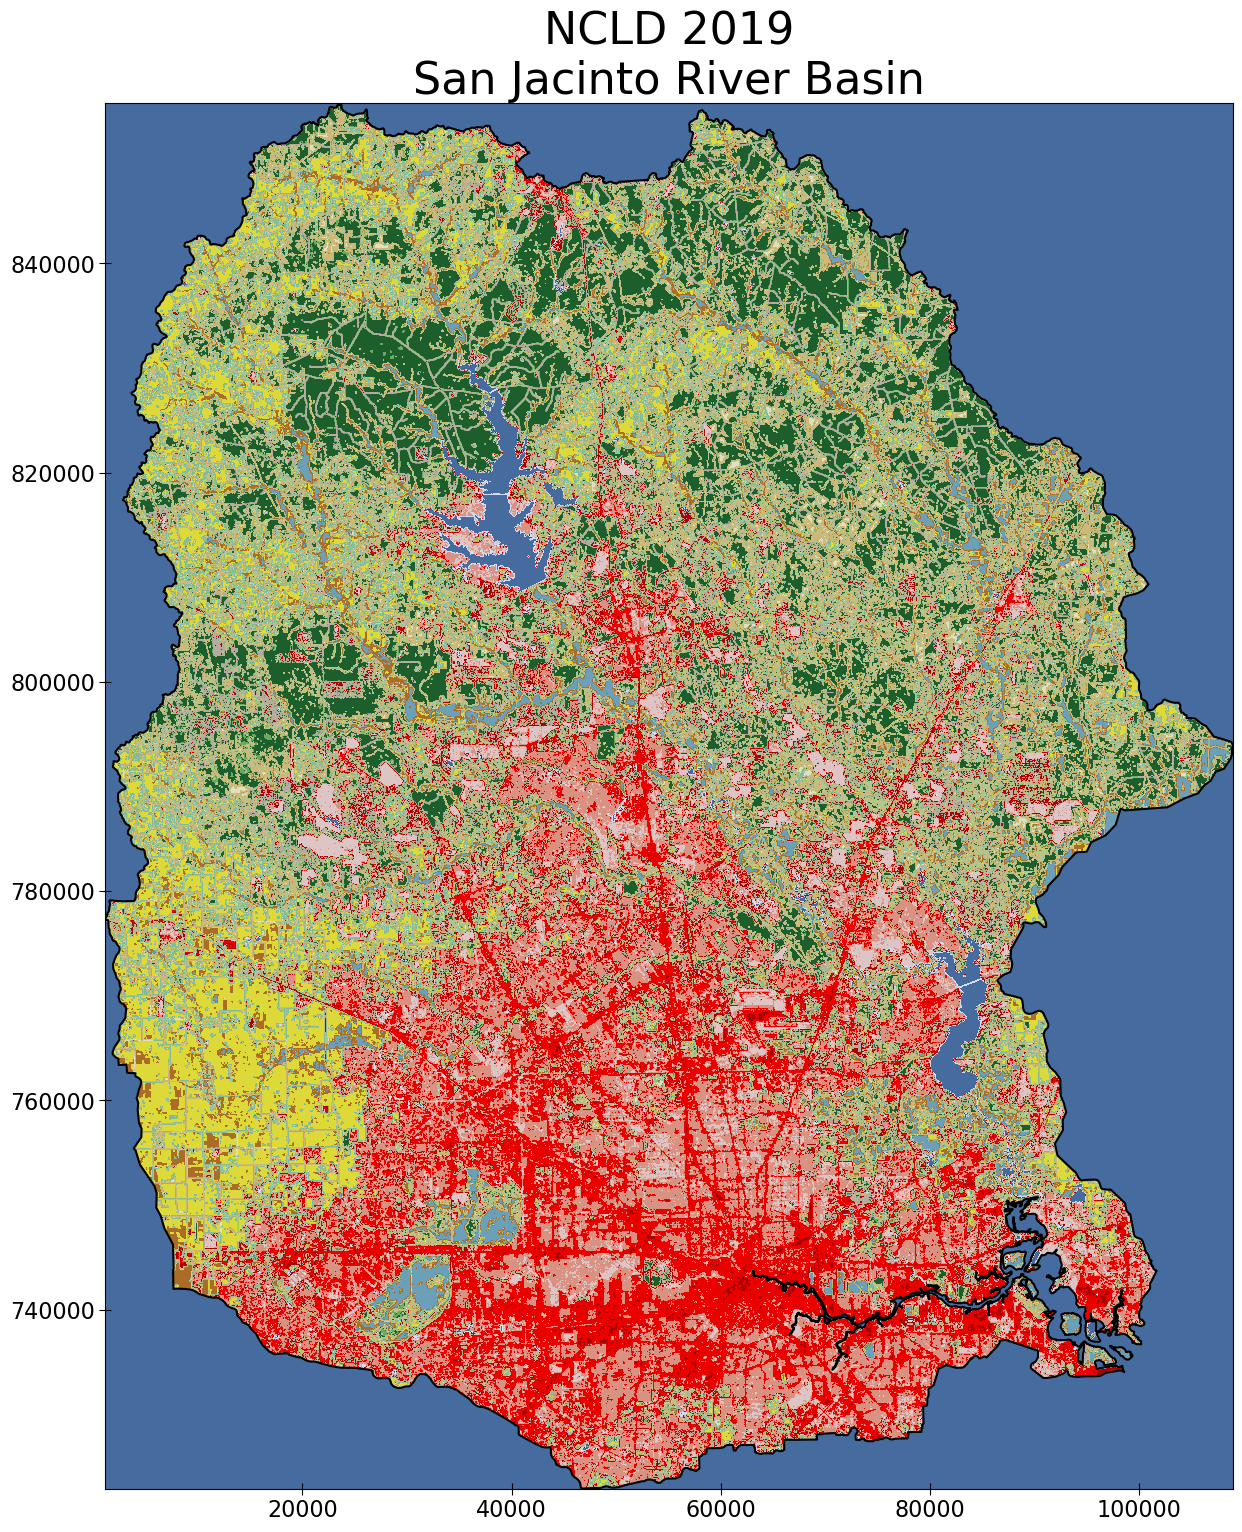

In [21]:
# Open the raster
with rasterio.open("NLCD_2019_Hockley_HUC.img") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Generate a mask from the shapefile
    #mask = geometry_mask(AGRO_Watershed.geometry, transform=src.transform, invert=True, out_shape=src.shape)
    # Mask the data outside the shapefile with NaN
    #data_masked = np.ma.masked_where(mask, data)
    # Mask no-data values
    #nodata_value = src.nodata
    #mask_data = np.ma.masked_where(data == nodata_value, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Display the raster using the raster_extent
img = ax.imshow(data, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 

# Add colorbar with tick marks
#cbar = fig.colorbar(img, ax=ax, orientation='vertical', pad=0.01, aspect=5, shrink=0.333)  
#cbar.ax.tick_params(labelsize=14)

# Set title and labels
ax.set_title('NCLD 2019\nSan Jacinto River Basin', fontsize=32)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
Hockly_HUCs_reprojected.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
fig.savefig("Chomiak_TX_Images_2023\TX_NCLD_Hockley_HUC_AEA_Spring.png", dpi=800, bbox_inches='tight')

# Close the figure without displaying it
#plt.close(fig)

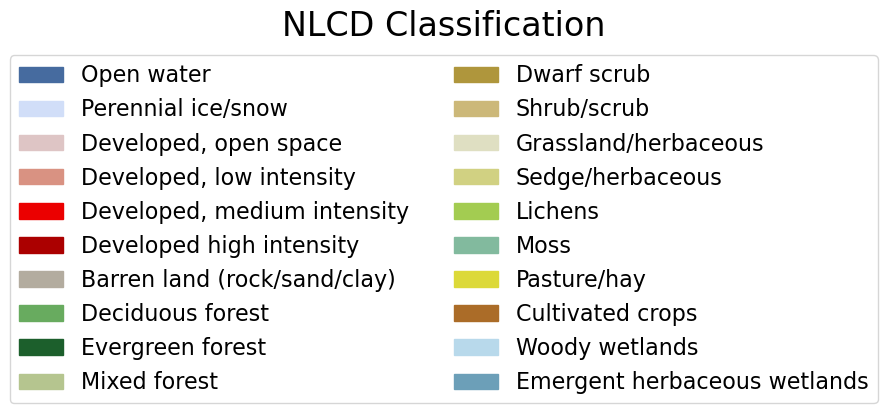

In [23]:
labels_1 = df['Name'].tolist()
colors_1 = df['Color'].tolist()

# Create a list of patches for the legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors_1, labels_1)]

# Create the figure for the legend
fig, ax = plt.subplots(figsize=(6, 3))  # Adjust the size based on the number of columns you want
ax.legend(handles=patches, loc='upper center', fontsize=16, ncol=2)  # Adjust ncol as needed
ax.axis('off')  # Turn off the axis
plt.title("NLCD Classification", fontsize=24)
plt.tight_layout()
plt.show()
#fig.savefig('Chomiak_TX_Images_2023\TX_NCLD_Hockley_HUC_Legend.png', dpi = 500, bbox_inches='tight')

# Clip to Spring Watershed

In [24]:
with rasterio.open('NLCD_2019_Hockley_HUC.img') as src:
    # Clip the raster
    clipped_image, clipped_transform = mask(src, h2_reprojected.geometry, crop=True)
    clipped_meta = src.meta
    
    # Update metadata after clipping
    clipped_meta.update({
        "driver": "GTiff",
        "height": clipped_image.shape[1],
        "width": clipped_image.shape[2],
        "transform": clipped_transform
    })
    
    # Save the clipped raster
    with rasterio.open("NLCD_2019_HUC_SJRB_Spring.img", "w", **clipped_meta) as dest:
        dest.write(clipped_image)

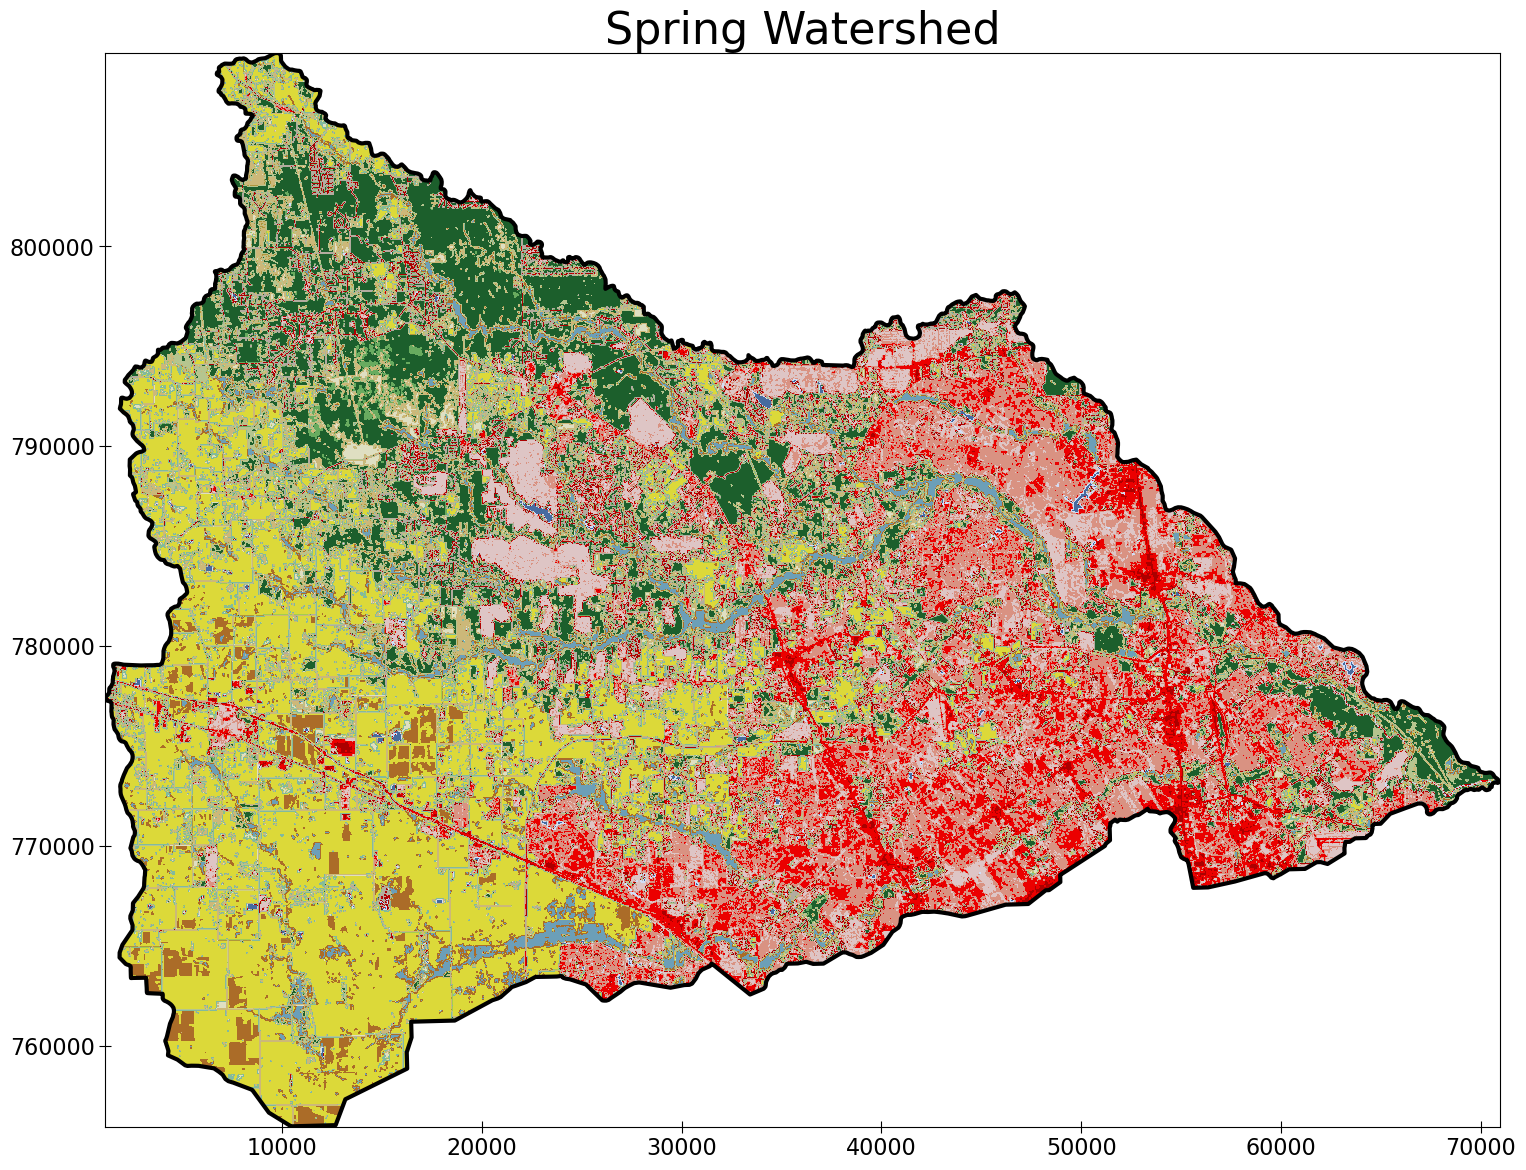

In [25]:
# Open the raster
with rasterio.open("NLCD_2019_HUC_SJRB_Spring.img") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Create a masked array where the nodata values are masked out
    masked_array = np.ma.masked_where(data == src.nodata, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Display the raster using the raster_extent
img = ax.imshow(masked_array, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 


# Set title and labels
ax.set_title('Spring Watershed', fontsize=32)
#ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
#ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
h2_reprojected.plot(ax=ax, color='none', edgecolor='black', lw=3, zorder=6)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

#fig.savefig("Chomiak_TX_Images_2023\TX_NCLD_Hockley_HUC_AEA.png", dpi=800, bbox_inches='tight')
# Close the figure without displaying it
#plt.close(fig)

In [ ]:
# Each pixel is (30m by 30m)

In [26]:
# Open the raster
with rasterio.open("NLCD_2019_HUC_SJRB_Spring.img") as src:
    # Read the raster data
    img_data = src.read(1)
    # Get the resolution (assumes square pixels)
    pixel_size = abs(src.transform[0] * src.transform[4])
    # Count the unique values (excluding nodata)
    unique_values, counts = np.unique(img_data[img_data != src.nodata], return_counts=True)

# Convert pixel counts to areas
areas = counts * pixel_size
# Create a DataFrame
df_huc = pd.DataFrame({
    'Land_Class_Value': unique_values,
    'Pixel_Count': counts,
    'Area_m2': areas
})

# Use the map function to map the Land_Class_Value to its corresponding Name
df_huc['Name'] = df_huc['Land_Class_Value'].map(df.set_index('Value')['Name'])
df_huc['Color'] = df_huc['Land_Class_Value'].map(df.set_index('Value')['Color'])

# Calculate the total area for Shapefile and Raster File
total_area_m2 = h2_reprojected.geometry.area.sum()
relative_area_m2 = df_huc['Area_m2'].sum()

# Calculate distributions for Shapefile and Raster File
df_huc['rel_distribution'] = (df_huc['Area_m2'] / relative_area_m2)*100
df_huc['total_distribution'] = (df_huc['Area_m2'] / total_area_m2)*100

In [27]:
df_huc = df_huc.sort_values(by='Area_m2', ascending=False)
df_huc

Land_Class_Value  Pixel_Count      Area_m2                          Name  \
11                81       601694  541524600.0                   Pasture/hay   
7                 42       338364  304527600.0              Evergreen forest   
3                 23       280788  252709200.0   Developed, medium intensity   
2                 22       262899  236609100.0      Developed, low intensity   
1                 21       211475  190327500.0         Developed, open space   
13                90       111670  100503000.0                Woody wetlands   
8                 43        94700   85230000.0                  Mixed forest   
4                 24        88557   79701300.0      Developed high intensity   
10                71        56183   50564700.0          Grassland/herbaceous   
12                82        45953   41357700.0              Cultivated crops   
9                 52        33027   29724300.0                   Shrub/scrub   
14                95        22164   19947600.0  Emergent herbaceous wetlands   
0                 11        15603   14042700.0                    Open water   
6                 41         8893    8003700.0              Deciduous forest   
5                 31         6071    5463900.0  Barren land (rock/sand/clay)   

      Color  rel_distribution  total_distribution  
11  #dcd939         27.625467           27.625488  
7   #1c5f2c         15.535245           15.535256  
3   #eb0000         12.891768           12.891778  
2   #d99282         12.070434           12.070443  
1   #dec5c5          9.709413            9.709421  
13  #b8d9eb          5.127084            5.127088  
8   #b5c58f          4.347944            4.347947  
4   #ab0000          4.065901            4.065904  
10  #dfdfc2          2.579520            2.579522  
12  #ab6c28          2.109832            2.109833  
9   #ccb879          1.516363            1.516364  
14  #6c9fb8          1.017612            1.017612  
0   #466b9f          0.716378            0.716378  
6   #68ab5f          0.408303            0.408303  
5   #b3ac9f          0.278737            0.278737

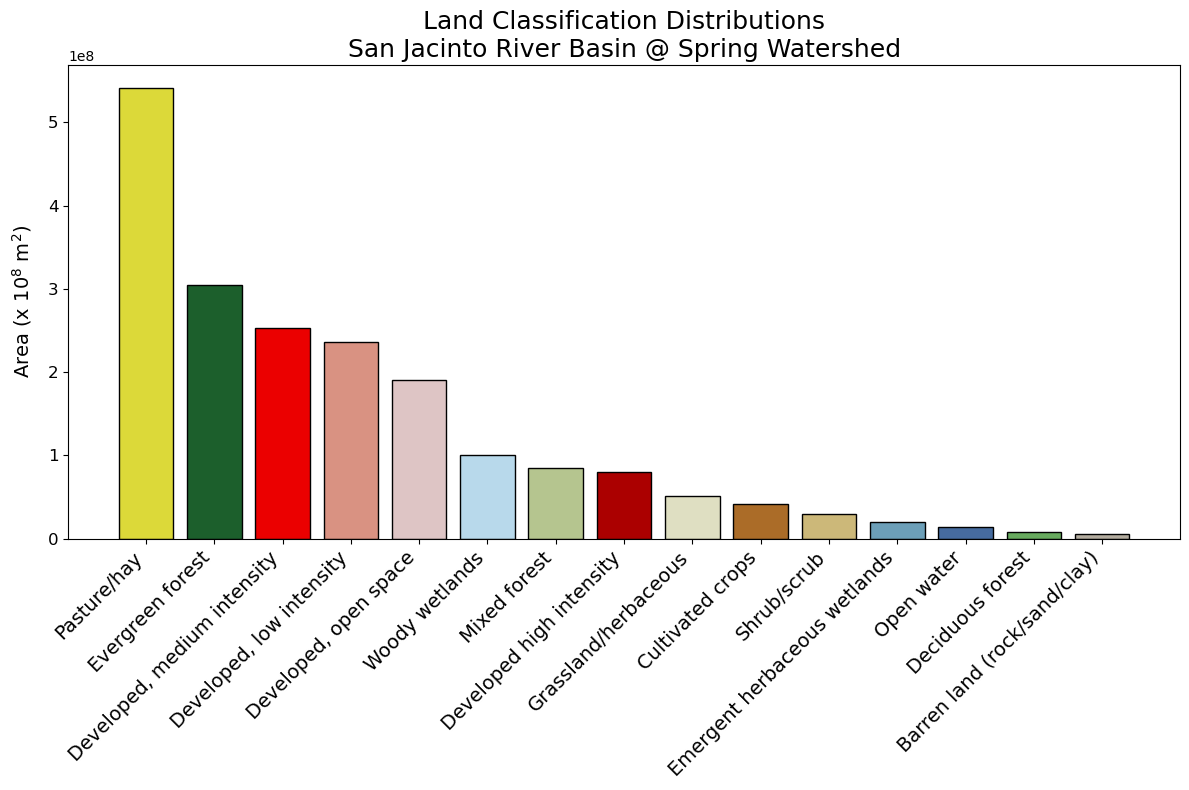

In [29]:
# Create the bar plot using the top 15 records
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(df_huc['Name'], df_huc['Area_m2'], color=df_huc['Color'], edgecolor='black', align='center')

# Set title and labels
ax.set_title('Land Classification Distributions\n San Jacinto River Basin @ Spring Watershed ', fontsize=18)
ax.set_ylabel('Area (x $10^8$ m$^2$)', fontsize=14, labelpad=10)
#ax.set_xlabel('Soil Taxonomic Classes', fontsize=14)

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=12)
fig.tight_layout()

fig.savefig("Chomiak_TX_Images_2023\2019_NLCD_HUC_SJRB_Spring_Barplot.png", dpi=600, bbox_inches='tight')

# Convert to EPSG 4326

In [30]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_raster(input_raster, output_raster, new_crs):
    """Reproject a raster to a new coordinate reference system."""
    with rasterio.open(input_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, new_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': new_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=new_crs,
                    resampling=Resampling.bilinear
                )
    print(f"Raster reprojected to {new_crs} and saved as {output_raster}.")

In [31]:
# Use the function to reproject the raster
new_crs = 'EPSG:4326'
huc_all = 'NLCD_2019_Hockley_HUC.img'
reproject_raster(huc_all, "NLCD_2019_HUC_SJRB_4326.tif", new_crs)

Raster reprojected to EPSG:4326 and saved as NLCD_2019_HUC_SJRB_4326.tif.


In [32]:
# Use the function to reproject the raster
new_crs = 'EPSG:4326'
huc_spring = "NLCD_2019_HUC_SJRB_Spring.img"
reproject_raster(huc_spring, "NLCD_2019_HUC_SJRB_Spring_4326.tif", new_crs)

Raster reprojected to EPSG:4326 and saved as NLCD_2019_HUC_SJRB_Spring_4326.tif.


# HydroSHEDS

In [33]:
HydroRIVERS_TX = gpd.read_file("HydroRIVERS_Texas")
print(HydroRIVERS_TX.crs)
print(HydroRIVERS_TX.shape)

epsg:4326
(32209, 16)


# Clip to San Jacinto River Basin

In [ ]:
# Clip to San Jacinto River Basin
#HydroRIVERS_TX_SJRB = HydroRIVERS_TX[HydroRIVERS_TX.within(huc.unary_union)]
#HydroRIVERS_TX_SJRB.to_file('HydroRIVERS_TX_SJRB\HydroRIVERS_TX_SJRB.shp', crs='EPSG:4326', driver = 'ESRI Shapefile')

In [49]:
# Import
HydroRIVERS_TX_SJRB = gpd.read_file('HydroRIVERS_TX_SJRB')
print(HydroRIVERS_TX_SJRB.shape)
#HydroRIVERS_TX_SJRB.plot()

(428, 16)


In [50]:
# ORD_FLOW
HydroRIVERS_flow_1 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 1]
HydroRIVERS_flow_2 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 2]
HydroRIVERS_flow_3 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 3]
HydroRIVERS_flow_4 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 4]
HydroRIVERS_flow_5 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 5]
HydroRIVERS_flow_6 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 6]
HydroRIVERS_flow_7 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 7]
HydroRIVERS_flow_8 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 8]
HydroRIVERS_flow_9 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 9]
HydroRIVERS_flow_10 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 10]
HydroRIVERS_flow_11 = HydroRIVERS_TX_SJRB.loc[HydroRIVERS_TX_SJRB['ORD_FLOW'] == 11]

print('Shapes:')
print('HydroRIVERS_flow_1: ', HydroRIVERS_flow_1.shape)
print('HydroRIVERS_flow_2: ', HydroRIVERS_flow_2.shape)
print('HydroRIVERS_flow_3: ', HydroRIVERS_flow_3.shape)
print('HydroRIVERS_flow_4: ', HydroRIVERS_flow_4.shape)
print('HydroRIVERS_flow_5: ', HydroRIVERS_flow_5.shape)
print('HydroRIVERS_flow_6: ', HydroRIVERS_flow_6.shape)
print('HydroRIVERS_flow_7: ', HydroRIVERS_flow_7.shape)
print('HydroRIVERS_flow_8: ', HydroRIVERS_flow_8.shape)
print('HydroRIVERS_flow_9: ', HydroRIVERS_flow_9.shape)
print('HydroRIVERS_flow_10: ', HydroRIVERS_flow_10.shape)
print('HydroRIVERS_flow_11: ', HydroRIVERS_flow_11.shape)

Shapes:
HydroRIVERS_flow_1:  (0, 16)
HydroRIVERS_flow_2:  (0, 16)
HydroRIVERS_flow_3:  (0, 16)
HydroRIVERS_flow_4:  (0, 16)
HydroRIVERS_flow_5:  (31, 16)
HydroRIVERS_flow_6:  (125, 16)
HydroRIVERS_flow_7:  (264, 16)
HydroRIVERS_flow_8:  (8, 16)
HydroRIVERS_flow_9:  (0, 16)
HydroRIVERS_flow_10:  (0, 16)
HydroRIVERS_flow_11:  (0, 16)


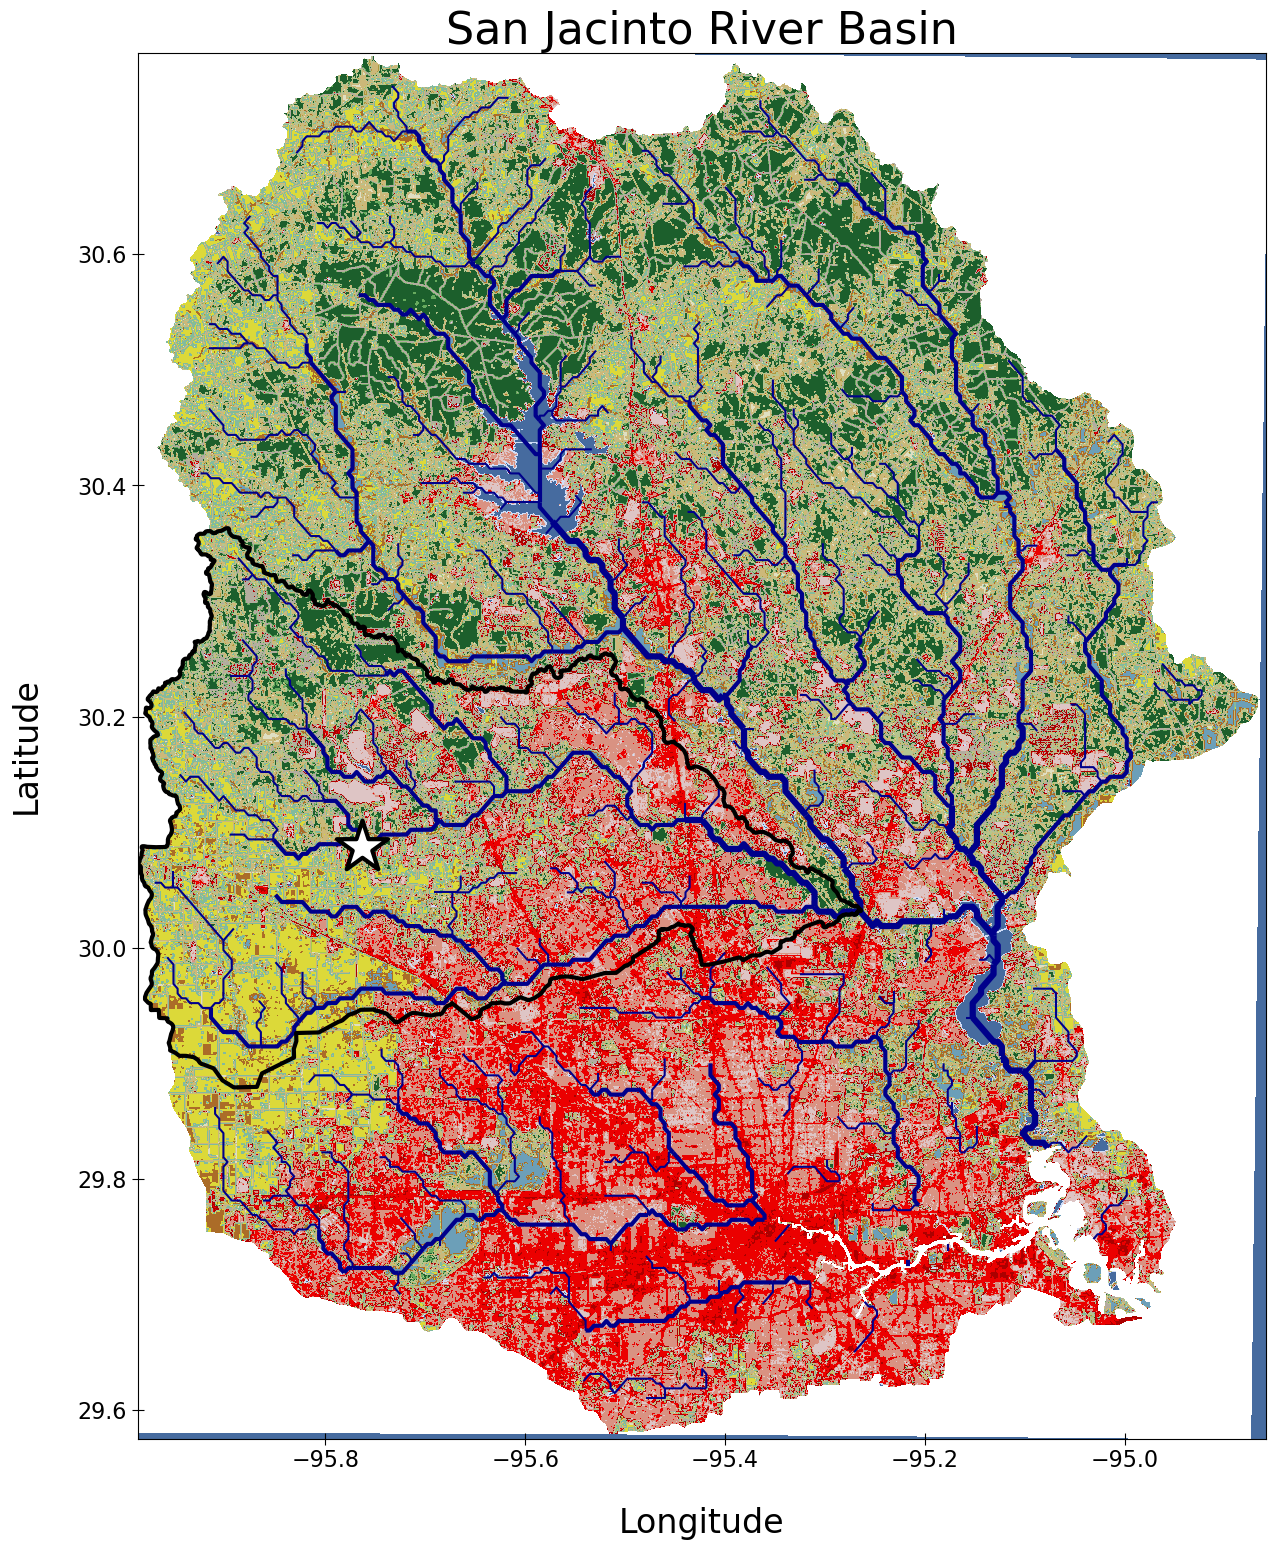

In [51]:
# Open the raster
with rasterio.open("NLCD_2019_HUC_SJRB_4326.tif") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Create a masked array where the nodata values are masked out
    masked_array = np.ma.masked_where(data == src.nodata, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Display the raster using the raster_extent
img = ax.imshow(masked_array, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 


# Set title and labels
ax.set_title('San Jacinto River Basin', fontsize=32)
ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
#huc.plot(ax=ax, color='none', edgecolor='black', lw=3, zorder=6)
h2.plot(ax=ax, color='none', edgecolor='black', lw=3, zorder=6)
sample_location.plot(ax=ax, color='white', edgecolor='black', marker='*', markersize=1500, lw=3, zorder=6)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Hydrology
#HydroRIVERS_TX_SJRB_Spring.plot(ax=ax, column='ORD_FLOW', color='darkblue', lw=4, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
HydroRIVERS_flow_5.plot(ax=ax, color='darkblue', lw=4.5, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
HydroRIVERS_flow_6.plot(ax=ax, color='darkblue', lw=3.0, zorder=4, label='10$^0$ - 10$^1$ [m$^3$/s]')
HydroRIVERS_flow_7.plot(ax=ax, color='darkblue', lw=1.5, zorder=3, label='10$^{-1}$ - 10$^0$ [m$^3$/s]')

fig.savefig("Chomiak_TX_Images_2023\TX_NCLD_2019_SJRB_EPSG_4326_1.png", dpi=800, bbox_inches='tight')
# Close the figure without displaying it
#plt.close(fig)

In [ ]:
# Open the raster
with rasterio.open("NLCD_2019_HUC_SJRB_4326.tif") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Create a masked array where the nodata values are masked out
    masked_array = np.ma.masked_where(data == src.nodata, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Display the raster using the raster_extent
img = ax.imshow(masked_array, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 


# Set title and labels
ax.set_title('Spring Watershed', fontsize=32)
ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
h2.plot(ax=ax, color='none', edgecolor='black', lw=3, zorder=6)
sample_location.plot(ax=ax, color='white', edgecolor='black', marker='*', markersize=1500, lw=3, zorder=6)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Hydrology
#HydroRIVERS_TX_SJRB_Spring.plot(ax=ax, column='ORD_FLOW', color='darkblue', lw=4, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
HydroRIVERS_flow_5.plot(ax=ax, color='darkblue', lw=4.5, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
HydroRIVERS_flow_6.plot(ax=ax, color='darkblue', lw=3.0, zorder=4, label='10$^0$ - 10$^1$ [m$^3$/s]')
HydroRIVERS_flow_7.plot(ax=ax, color='darkblue', lw=1.5, zorder=3, label='10$^{-1}$ - 10$^0$ [m$^3$/s]')

#fig.savefig("Chomiak_TX_Images_2023\TX_NCLD_2019_Spring_Watershed_EPSG_4326.png", dpi=800, bbox_inches='tight')
# Close the figure without displaying it
#plt.close(fig)

In [ ]:
halt

# Clip to San Jacinto River Basin @ Spring Watershed

In [ ]:
# Clip to San Jacinto River Basin @ Spring Watershed
#HydroRIVERS_TX_SJRB_Spring = HydroRIVERS_TX[HydroRIVERS_TX.within(h2.unary_union)]
#HydroRIVERS_TX_SJRB_Spring.to_file('HydroRIVERS_TX_SJRB_Spring\HydroRIVERS_TX_SJRB_Spring.shp', crs='EPSG:4326', driver = 'ESRI Shapefile')

(74, 16)


<AxesSubplot:>

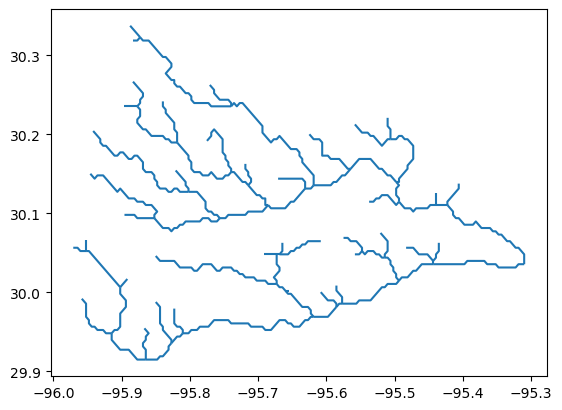

In [44]:
# Import
HydroRIVERS_TX_SJRB_Spring = gpd.read_file('HydroRIVERS_TX_SJRB_Spring')
print(HydroRIVERS_TX_SJRB_Spring.shape)
HydroRIVERS_TX_SJRB_Spring.plot()

In [45]:
# Reproject the shapefile to match the raster's CRS
raster_crs = 'PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
HydroRIVERS_TX_SJRB_Spring_reprojected = HydroRIVERS_TX_SJRB_Spring.to_crs(raster_crs)

In [54]:
# ORD_FLOW
HydroRIVERS_flow_1 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 1]
HydroRIVERS_flow_2 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 2]
HydroRIVERS_flow_3 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 3]
HydroRIVERS_flow_4 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 4]
HydroRIVERS_flow_5 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 5]
HydroRIVERS_flow_6 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 6]
HydroRIVERS_flow_7 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 7]
HydroRIVERS_flow_8 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 8]
HydroRIVERS_flow_9 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 9]
HydroRIVERS_flow_10 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 10]
HydroRIVERS_flow_11 = HydroRIVERS_TX_SJRB_Spring.loc[HydroRIVERS_TX_SJRB_Spring['ORD_FLOW'] == 11]

print('Shapes:')
print('HydroRIVERS_flow_1: ', HydroRIVERS_flow_1.shape)
print('HydroRIVERS_flow_2: ', HydroRIVERS_flow_2.shape)
print('HydroRIVERS_flow_3: ', HydroRIVERS_flow_3.shape)
print('HydroRIVERS_flow_4: ', HydroRIVERS_flow_4.shape)
print('HydroRIVERS_flow_5: ', HydroRIVERS_flow_5.shape)
print('HydroRIVERS_flow_6: ', HydroRIVERS_flow_6.shape)
print('HydroRIVERS_flow_7: ', HydroRIVERS_flow_7.shape)
print('HydroRIVERS_flow_8: ', HydroRIVERS_flow_8.shape)
print('HydroRIVERS_flow_9: ', HydroRIVERS_flow_9.shape)
print('HydroRIVERS_flow_10: ', HydroRIVERS_flow_10.shape)
print('HydroRIVERS_flow_11: ', HydroRIVERS_flow_11.shape)

Shapes:
HydroRIVERS_flow_1:  (0, 16)
HydroRIVERS_flow_2:  (0, 16)
HydroRIVERS_flow_3:  (0, 16)
HydroRIVERS_flow_4:  (0, 16)
HydroRIVERS_flow_5:  (2, 16)
HydroRIVERS_flow_6:  (25, 16)
HydroRIVERS_flow_7:  (47, 16)
HydroRIVERS_flow_8:  (0, 16)
HydroRIVERS_flow_9:  (0, 16)
HydroRIVERS_flow_10:  (0, 16)
HydroRIVERS_flow_11:  (0, 16)


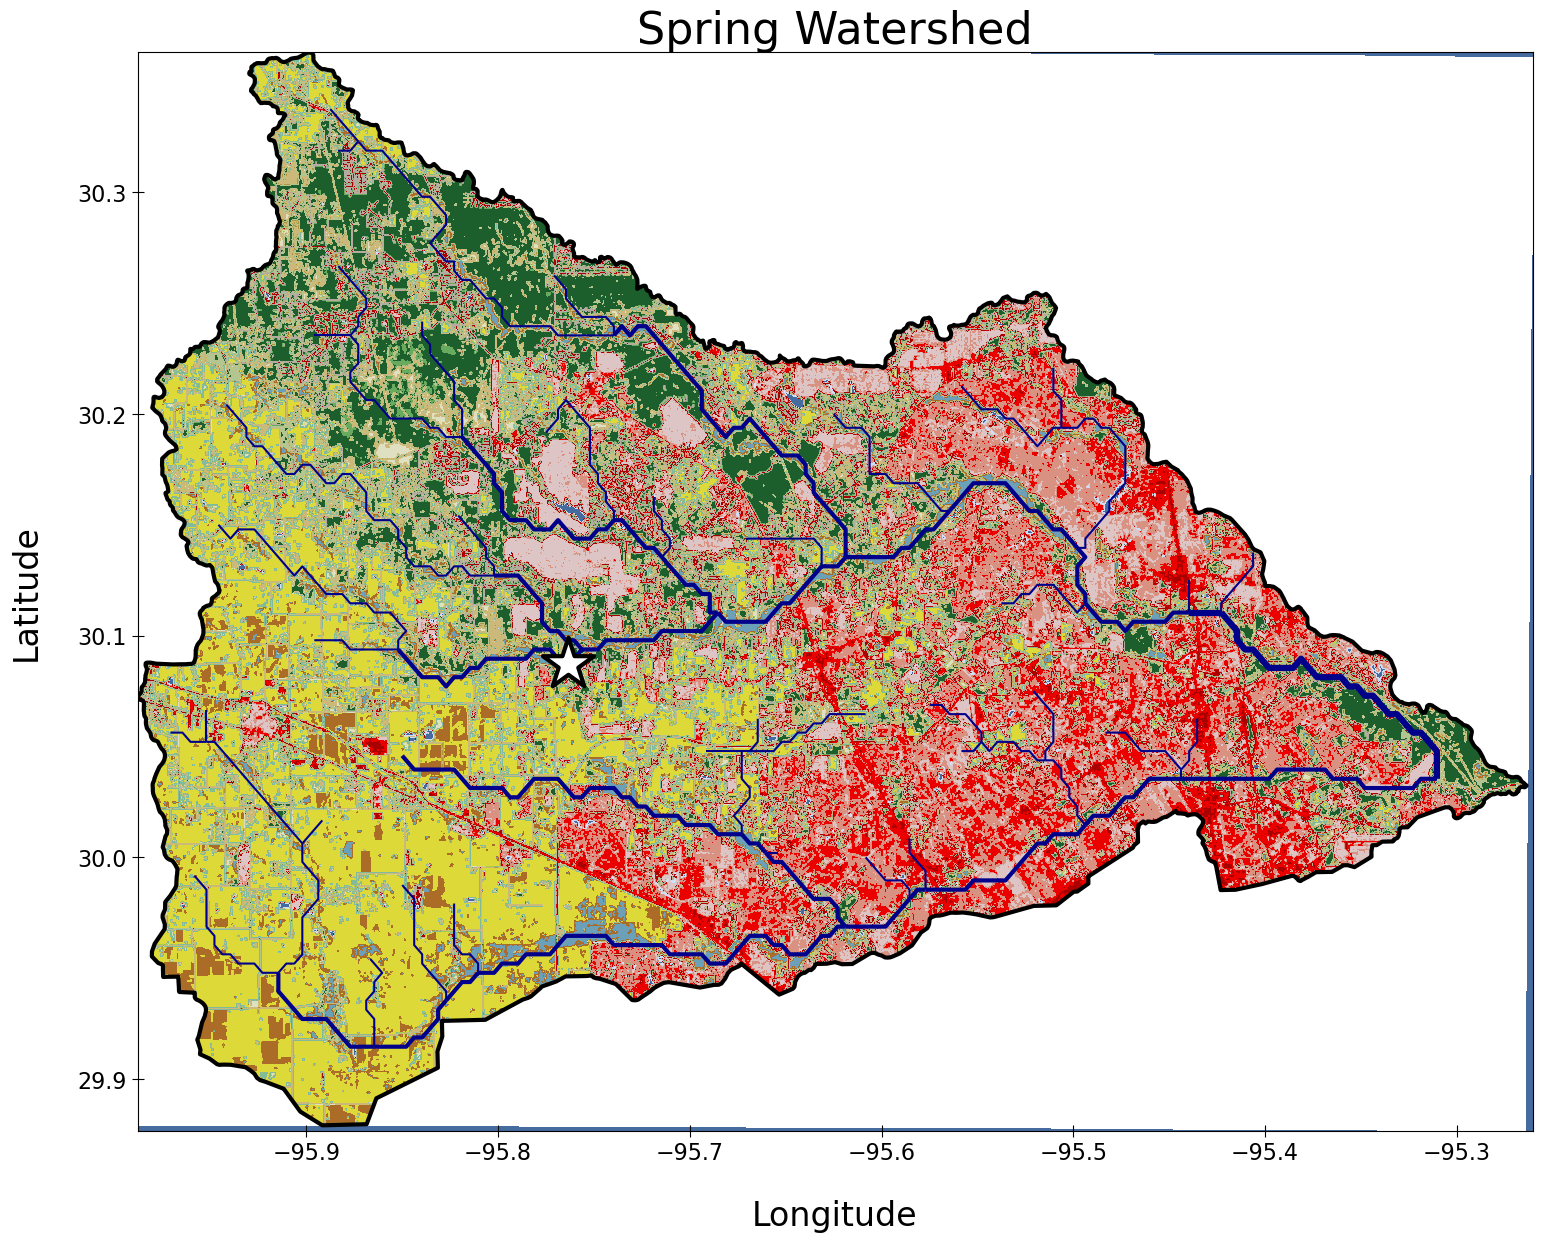

In [55]:
# Open the raster
with rasterio.open("NLCD_2019_HUC_SJRB_Spring_4326.tif") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Create a masked array where the nodata values are masked out
    masked_array = np.ma.masked_where(data == src.nodata, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Display the raster using the raster_extent
img = ax.imshow(masked_array, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 


# Set title and labels
ax.set_title('Spring Watershed', fontsize=32)
ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
h2.plot(ax=ax, color='none', edgecolor='black', lw=3, zorder=6)
sample_location.plot(ax=ax, color='white', edgecolor='black', marker='*', markersize=1500, lw=3, zorder=6)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Hydrology
#HydroRIVERS_TX_SJRB_Spring.plot(ax=ax, column='ORD_FLOW', color='darkblue', lw=4, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
HydroRIVERS_flow_5.plot(ax=ax, color='darkblue', lw=4.5, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
HydroRIVERS_flow_6.plot(ax=ax, color='darkblue', lw=3.0, zorder=4, label='10$^0$ - 10$^1$ [m$^3$/s]')
HydroRIVERS_flow_7.plot(ax=ax, color='darkblue', lw=1.5, zorder=3, label='10$^{-1}$ - 10$^0$ [m$^3$/s]')

fig.savefig("Chomiak_TX_Images_2023\TX_NCLD_2019_SJRB_Spring_EPSG_4326_1.png", dpi=800, bbox_inches='tight')
# Close the figure without displaying it
#plt.close(fig)

In [56]:
bounding_box_epsg_4326 = gpd.read_file('bounding_box_epsg_4326')

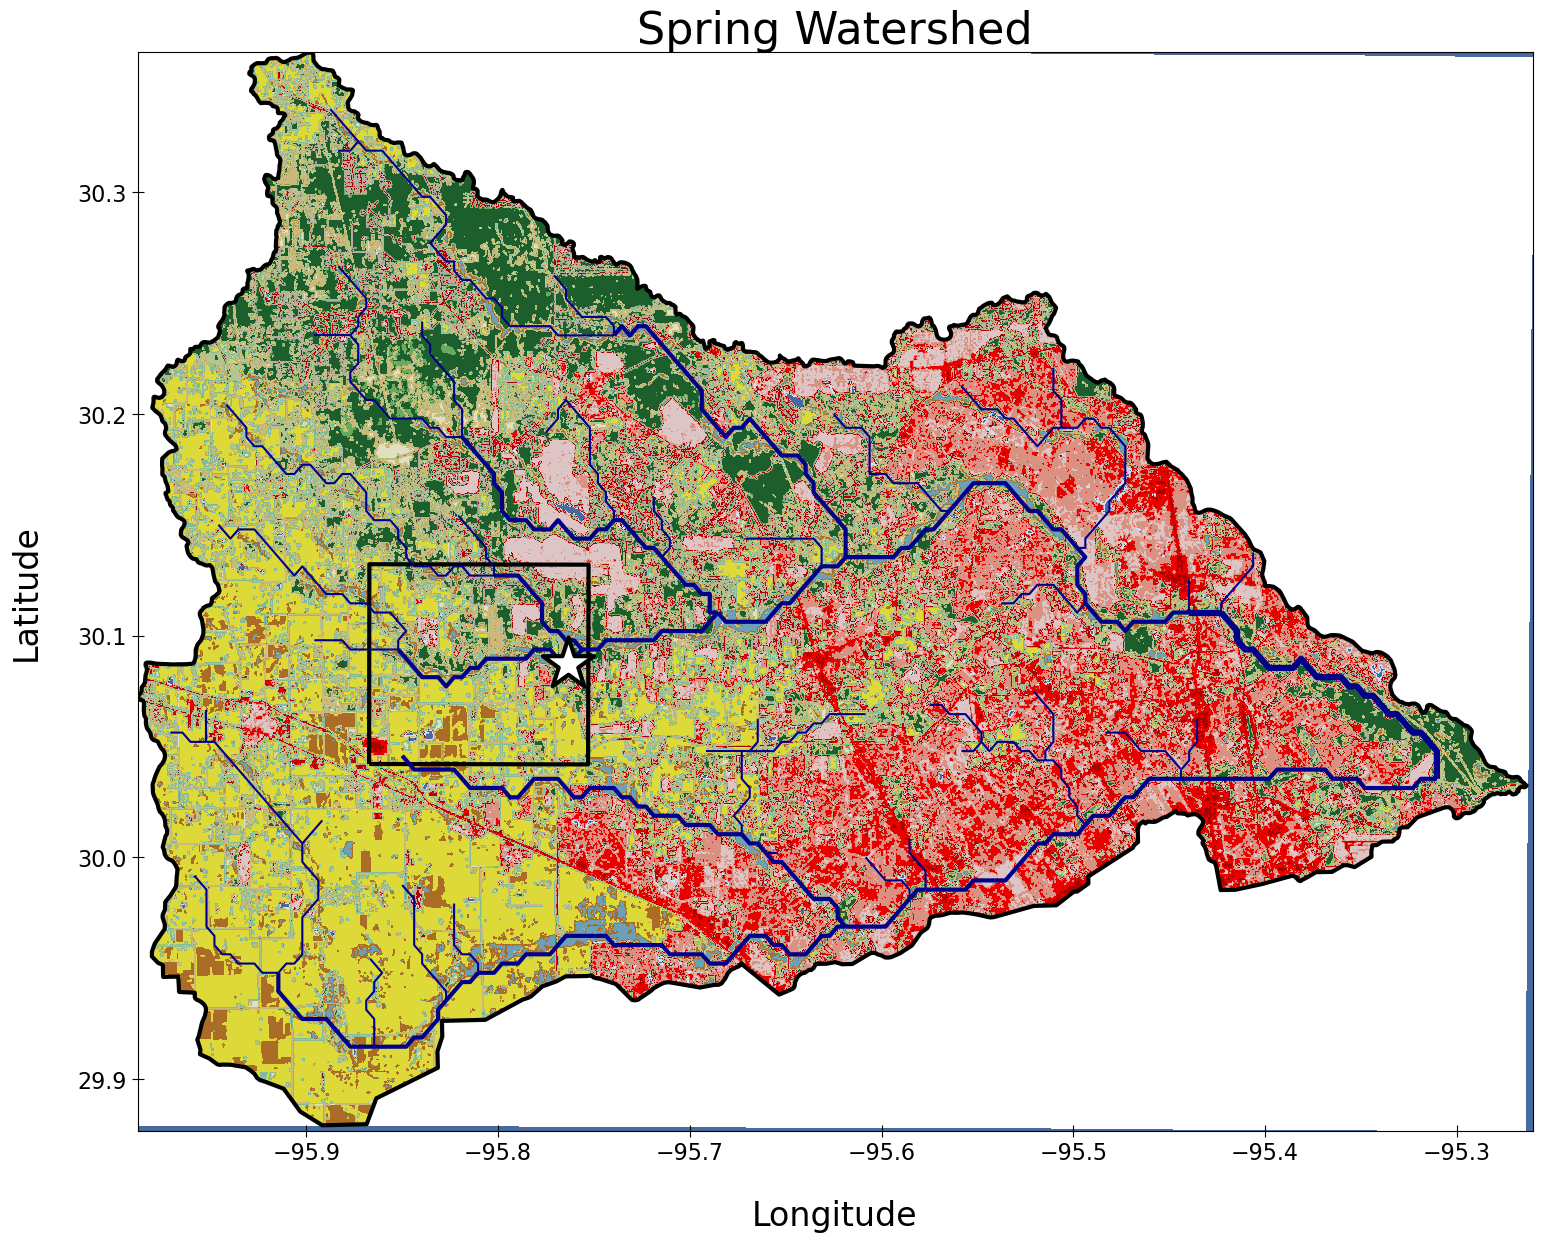

In [57]:
# Open the raster
with rasterio.open("NLCD_2019_HUC_SJRB_Spring_4326.tif") as src:
    # Read the data
    data = src.read(1)
    # Get the raster's bounds
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Create a masked array where the nodata values are masked out
    masked_array = np.ma.masked_where(data == src.nodata, data)
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 18))

# Display the raster using the raster_extent
img = ax.imshow(masked_array, cmap=cmap, norm=norm, extent=raster_extent) # cmap=cmap, norm=norm, 


# Set title and labels
ax.set_title('Spring Watershed', fontsize=32)
ax.set_xlabel('Longitude', color='black', fontsize=24, labelpad=25)
ax.set_ylabel('Latitude', color='black', fontsize=24, labelpad=25)
h2.plot(ax=ax, color='none', edgecolor='black', lw=3, zorder=6)
bounding_box_epsg_4326.plot(ax=ax, color='none', edgecolor='black', lw=3)
sample_location.plot(ax=ax, color='white', edgecolor='black', marker='*', markersize=1500, lw=3, zorder=6)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16)

# Hydrology
#HydroRIVERS_TX_SJRB_Spring.plot(ax=ax, column='ORD_FLOW', color='darkblue', lw=4, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
HydroRIVERS_flow_5.plot(ax=ax, color='darkblue', lw=4.5, zorder=3, label='10$^1$ - 10$^2$ [m$^3$/s]')
HydroRIVERS_flow_6.plot(ax=ax, color='darkblue', lw=3.0, zorder=4, label='10$^0$ - 10$^1$ [m$^3$/s]')
HydroRIVERS_flow_7.plot(ax=ax, color='darkblue', lw=1.5, zorder=3, label='10$^{-1}$ - 10$^0$ [m$^3$/s]')

fig.savefig("Chomiak_TX_Images_2023\TX_NCLD_2019_SJRB_Spring_EPSG_4326_2.png", dpi=800, bbox_inches='tight')
# Close the figure without displaying it
#plt.close(fig)